Built and compared interpretable and ensemble models for classificationtasks using real-world loan approvaldatasets. Applied OLS/Logit/Scikit Learn and CART as baselines, then improved performance using Random Forest and XGBoost with cross-validation and hyperparameter tuning. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#  Classification comparison using LOGIT/ SciKit Learn/CART/ RF/ XGBoost with hyperparameter tuning


#### ALL about data and split

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/JPProjects/loans.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516 entries, 0 to 9515
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   default      9516 non-null   int64  
 1   installment  9516 non-null   int64  
 2   log_income   9516 non-null   float64
 3   fico_score   9516 non-null   int64  
 4   rev_balance  9516 non-null   float64
 5   inquiries    9516 non-null   int64  
 6   records      9516 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 520.5 KB


In [ ]:
df.head(1)

,default,installment,log_income,fico_score,rev_balance,inquiries,records
0,0,829,4.93,737,28.85,0,0


In [ ]:
df['default'].value_counts(normalize=True)

,proportion
default,
0,0.840164
1,0.159836


#### Training and Test DataSets

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
X_train = df_train.copy()
y_train = X_train.pop('default')
X_test = df_test.copy()
y_test = X_test.pop('default')

### Understanding Confusion Matrix and Profit Calculation
- The actual outcomes (`y_test`) are binary values:
  - `0` = No default
  - `1` = Default
- The model outputs probabilities (e.g., `0.72`, `0.35`, etc.), **not class labels**.
- To convert probabilities into class predictions, we apply a **cutoff threshold**:
  - If predicted probability ≥ cutoff → classify as `1` (default)
  - If predicted probability < cutoff → classify as `0` (no default)
- After applying the cutoff, we compare predicted labels to actual labels to create a **confusion matrix**:
  - **True Negative (TN):** Predicted no default, and actually no default
  - **False Positive (FP):** Predicted default, but actually no default
  - **False Negative (FN):** Predicted no default, but actually default (costly!)
  - **True Positive (TP):** Predicted default, and actually default
- Using the confusion matrix, we compute **profit per applicant**:
  - Earn 1000 dollars for every correctly predicted non-default (TN)
  - Lose 5000 dollars for every missed default (FN)
- We repeat this for a range of cutoff values (e.g., 0.1 to 0.9) and select the one that **maximizes profit**, not just accuracy.
- This allows us to align model evaluation with real-world business impact.

#### Helper functions

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

def profit(y, y_pred, cutoff=0.5, verbose=False):
  '''
  Given a probability cutoff, predicted probabilities, and actual y values,
  calculates the profit per applicant
  '''
  will_default = np.where(y_pred >= cutoff, 1, 0)
  cm = confusion_matrix(y, will_default)
  if verbose:
    ConfusionMatrixDisplay.from_predictions(
        y,
        will_default,
        display_labels = ['No Default', 'Default']
        )
  cm_profit = 1000*cm[0,0]-5000*cm[1,0]
  return cm_profit/len(y)

def profit_table(y, y_pred, cutoffs=np.arange(0,1.01,0.1)):
  '''
  Given predicted probabilities, actual y values, and a set of cutoffs,
  calculates the profit per applicant for each cutoff
  and returns it in a two-column dataframe
  '''
  return pd.DataFrame({'cutoff': cutoffs,
                       'profit': [profit(y, y_pred, cutoff) for cutoff in cutoffs]})

def best_profit_and_cutoff(y, y_pred):
  '''
  Given predicted probabilities and actual y values, returns the optimal
  cutoff and optimal profit per applicant
  '''
  pf = profit_table(y, y_pred)
  idx = pf.profit.idxmax()
  return pf.loc[idx]

def viz_tree(tree, font=12, figsize=(16,10)):
  '''
  draws a classification tree
  '''
  plt.figure(figsize=figsize)  # set plot size (denoted in inches)
  _ = plot_tree(tree,
                feature_names=X.columns,
                filled=True,
                fontsize=font)

## Build Logistic Regression using scikit learn

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1e6, solver='lbfgs', max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(C=1000000.0, class_weight='balanced', max_iter=1000)

### Scikit Learn Results

In [ ]:
y_pred = model.predict_proba(X_test)[:, 1] # to apply cutoff after
profit_table(y_test,y_pred)

,cutoff,profit
0,0.0,0.000000
1,0.1,0.700525
2,0.2,24.518389
3,0.3,94.220665
4,0.4,168.126095
5,0.5,182.486865
6,0.6,152.364273
7,0.7,125.043783
8,0.8,60.595447
9,0.9,39.229422


## Build Logistic Regression using LOGIT


### Model using LOGIT

In [ ]:
from statsmodels.formula.api import logit
formula="default ~ installment + log_income + fico_score + rev_balance + inquiries + records"
est = logit(formula=formula, data=df_train).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.415078
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 6661
Model:                          Logit   Df Residuals:                     6654
Method:                           MLE   Df Model:                            6
Date:                Tue, 20 May 2025   Pseudo R-squ.:                 0.05338
Time:                        15:58:13   Log-Likelihood:                -2764.8
converged:                       True   LL-Null:                       -2920.7
Covariance Type:            nonrobust   LLR p-value:                 2.415e-64
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       9.7634      0.994      9.824      0.000       7.816      11.711
installment     0.0013    

### Prediction using LOGIT

In [ ]:
y_pred = est.predict(X_test)
profit_table(y_test, y_pred)

,cutoff,profit
0,0.0,0.000000
1,0.1,152.014011
2,0.2,153.415061
3,0.3,113.835377
4,0.4,57.793345
5,0.5,42.732049
6,0.6,32.574431
7,0.7,32.924694
8,0.8,32.924694
9,0.9,33.274956


At cutoff of 0.2 the logistic regression model has a profit of 153$ whereas Default CART has profit of ~74

## Build CART with default parameters

### Model using CART

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

<a id="default-cart-results"></a>
### Default CART Results

In [ ]:
y_pred = tree.predict_proba(X_test)[:,1]
profit_table(y_test, y_pred)

,cutoff,profit
0,0.0,0.000000
1,0.1,74.255692
2,0.2,74.255692
3,0.3,74.255692
4,0.4,74.255692
5,0.5,74.255692
6,0.6,74.255692
7,0.7,74.255692
8,0.8,74.255692
9,0.9,74.255692


In [ ]:
tree.tree_.max_depth, tree.tree_.node_count
#big Tree

(35, 2515)

## Build CART with Cost Complexity pruning

In [ ]:
tree = DecisionTreeClassifier(random_state=42)
path = tree.cost_complexity_pruning_path(X_train,y_train)
alphas = path.ccp_alphas

In [ ]:
trees = []
for alpha in alphas:
  tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
  tree.fit(X_train,y_train)
  trees.append(tree)
print(f"This process generated {len(trees)} trees.")

This process generated 436 trees.


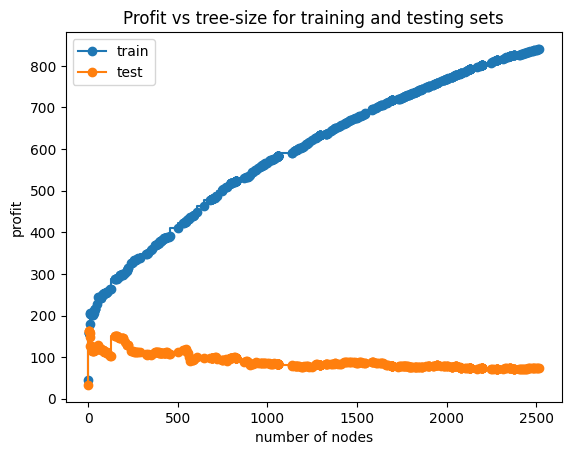

In [ ]:
def all_trees_profits_cutoffs(X,y):
  max_profit = []
  best_cutoff = []
  for tree in trees:
    y_pred = tree.predict_proba(X)[:,1]
    pf = best_profit_and_cutoff(y, y_pred)
    max_profit.append(pf['profit'])
    best_cutoff.append(pf['cutoff'])
  return max_profit, best_cutoff
train_profits, train_cutoffs = all_trees_profits_cutoffs(X_train,y_train)
test_profits, test_cutoffs = all_trees_profits_cutoffs(X_test,y_test)

node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]
fig, ax = plt.subplots()
ax.set_xlabel("number of nodes")
ax.set_ylabel("profit")
ax.set_title("Profit vs tree-size for training and testing sets")
ax.plot(node_counts, train_profits, marker="o", label="train", drawstyle="steps-post")
ax.plot(node_counts, test_profits, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
test_profits[-5:], test_cutoffs[-5:]

([np.float64(148.86164623467602),
  np.float64(161.8213660245184),
  np.float64(161.8213660245184),
  np.float64(161.8213660245184),
  np.float64(33.274956217162874)],
 [np.float64(0.2),
  np.float64(0.2),
  np.float64(0.2),
  np.float64(0.2),
  np.float64(0.2)])

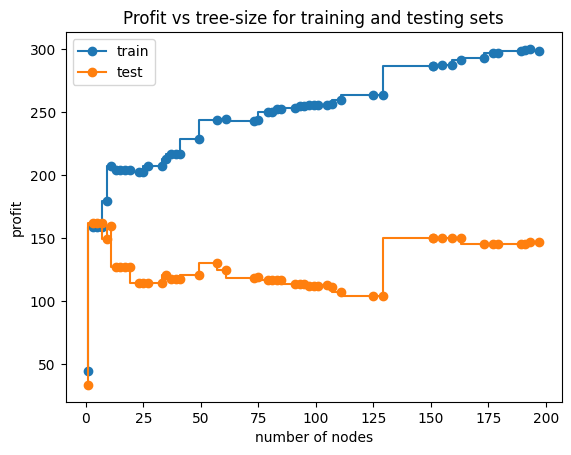

In [ ]:
# Zoom in on the first 50 nodes
fig, ax = plt.subplots()
ax.set_xlabel("number of nodes")
ax.set_ylabel("profit")
ax.set_title("Profit vs tree-size for training and testing sets")
ax.plot(node_counts[-50:], train_profits[-50:], marker="o", label="train", drawstyle="steps-post")
ax.plot(node_counts[-50:], test_profits[-50:], marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

<a id="ccp-cart-results"></a>
### CCP CART results

In [ ]:
opt_idx = np.argmax(test_profits)
print(opt_idx)
print(f"Profit of max-profit tree = ${max(test_profits):.2f}")
print(f"Size of max-profit tree = {node_counts[opt_idx]} nodes")
print(f"Optimal cutoff for chosen tree = {test_cutoffs[opt_idx]:.2f}")

432
Profit of max-profit tree = $161.82
Size of max-profit tree = 7 nodes
Optimal cutoff for chosen tree = 0.20


## Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#100 variations of data;
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict_proba(X_test)[:,1]
profit_table(y_test, y_pred)


,cutoff,profit
0,0.0,0.000000
1,0.1,133.800350
2,0.2,153.415061
3,0.3,97.723292
4,0.4,61.295972
5,0.5,41.330998
6,0.6,37.828371
7,0.7,36.077058
8,0.8,33.274956
9,0.9,33.274956


## *XGBoost*

In [ ]:
import xgboost as xgb
xg_model = xgb.XGBClassifier(random_state=42)
xg_model.fit(X_train, y_train)
y_pred = xg_model.predict_proba(X_test)[:,1]
profit_table(y_test, y_pred)

,cutoff,profit
0,0.0,0.000000
1,0.1,143.257443
2,0.2,122.942207
3,0.3,94.220665
4,0.4,77.758319
5,0.5,53.940455
6,0.6,45.884413
7,0.7,42.381786
8,0.8,37.127846
9,0.9,34.676007


## *XGBoost* with GridSearch CV

It tunes hyperparameters only (e.g., tree depth, learning rate, number of trees)
It doesn't — and shouldn't — care about cutoffs.

➡️ During GridSearchCV, you use a placeholder cutoff (like 0.4) inside your custom scorer to rank models.

✅ After you get best_estimator_:
You extract probabilities like this:
y_pred_proba = gcv.best_estimator_.predict_proba(X_test)[:, 1]

profit_df = profit_table(y_test, y_pred_proba)
best = best_profit_and_cutoff(y_test, y_pred_proba)

Why this works because: The model’s job is to output well-calibrated probabilities.Your job is to define what cutoff best serves the business goal.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import make_scorer  # ✅ NEW

def custom_profit_score(y_true, y_pred_proba):
    y_pred = y_pred_proba
    return profit(y_true, y_pred, cutoff=0.4)

profit_scorer = make_scorer(custom_profit_score, response_method="predict_proba")

param_grid = {'n_estimators': [10,50,100],
              'max_depth': [1,2,3,4,5],
              'learning_rate': [0.001, 0.01, 0.1, 0.3]}

xg_model = xgb.XGBClassifier(
        eval_metric='logloss',
        random_state=42)


In [ ]:
gcv = GridSearchCV(estimator = xg_model,
                  param_grid=param_grid,
                  cv=5,
                  scoring=profit_scorer)
gcv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.3],
                         'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [10, 50, 100]},
             scoring=make_scorer(custom_profit_score, response_method='predict_proba'))

In [ ]:
gcv.best_params_

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100}

In [ ]:
y_pred = gcv.best_estimator_.predict_proba(X_test)[:,1]
profit_table(y_test, y_pred)

,cutoff,profit
0,0.0,0.000000
1,0.1,140.805604
2,0.2,107.530648
3,0.3,108.231173
4,0.4,79.159370
5,0.5,64.448336
6,0.6,45.884413
7,0.7,36.427320
8,0.8,36.427320
9,0.9,34.325744


## XGBoost with Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
param_grid = {'n_estimators': range(10,1010,10),
              'max_depth': range(1,21),
              'learning_rate': np.linspace(0.001, 1.0, 50)}

In [ ]:
rcv = RandomizedSearchCV(estimator = xg_model,
                        param_distributions = param_grid,
                        cv=5,
                        n_iter=10,
                        scoring=profit_scorer,
                        random_state=42)
rcv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
       0.61263265, 0.63302041, 0.65340816, 0.67379592, 0.69418367,
       0.71457143, 0.73495918, 0.75534694, 0.77573469, 0.79612245,
       0.8165102 , 0.83689796, 0.85728571, 0.87767347, 0.89806122,
       0.91844898, 0.93883673, 0.95922449, 0.97961224, 1.        ]),
                                        'max_depth': range(1, 21),
                                        'n_estimators': range(10, 1010, 10)},
                   random_state=42,
                   scoring=make_scorer(custom_profit_score, response_method='predict_proba'))

In [ ]:
rcv.best_params_

{'n_estimators': 870,
 'max_depth': 4,
 'learning_rate': np.float64(0.8368979591836735)}

In [ ]:
y_pred = rcv.best_estimator_.predict_proba(X_test)[:,1]
profit_table(y_test, y_pred)

,cutoff,profit
0,0.0,0.000000
1,0.1,94.921191
2,0.2,101.926445
3,0.3,74.605954
4,0.4,59.194396
5,0.5,42.381786
6,0.6,45.534151
7,0.7,50.437828
8,0.8,40.280210
9,0.9,32.924694


## 📊 Model Comparison Summary

| Model              | Max Profit / Applicant | Best Cutoff | Details |
|--------------------|------------------------|-------------|---------|
| [LOGIT (Statsmodels)]  | \$153.48                 | 0.20        |
| [Scikit-Learn Logistic Regression]| \$182.44                 | 0.5        |
| [CART (Default)]    | \$74.2| 0.20        
| [CART (CCP)]    | \$161.82| 0.20        
| [RANDOM Forests (RF)]| \$153.82| 0.20        
| [Basic XGBoost (XGB)]| \$143.82| 0.10      
| [GridSearch CV]| \$140.82| 0.10        
| [Randomized Search CV]| \$101.92| 0.10        

GridSearchCV was more effective here because the parameter space is small and structured — exhaustively checking all combinations paid off.

RandomizedSearchCV underperformed because It likely sampled less optimal combinations; and With limited iterations, it missed the sweet spots